In [6]:
import os
img_dir = 'img'
stylegan_gen_struc = os.path.join(img_dir, 'stylegan_generator_structure.png')
adain_form = os.path.join(img_dir, 'adain_formula.png')
early_styleconv_block = os.path.join(img_dir, 'Early_styleConv_Block.png')
intermediate_generator = os.path.join(img_dir, 'intermediate_generator.png')

In [7]:
# 필요한 모듈 import
import torch
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import math

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

%matplotlib inline

In [8]:
# PGGAN의 learning rate를 일정하게 해주는 기법
# runtime forward시에 weight에 he initialization 값으로 weight scale을 적용하는 모듈
class ScaleW:
    '''
    Constructor: name - name of attribute to be scaled
    Equalized learning rate : RMSProp이나 ADAM의 경우 gradient update에 대해 normalizing을 해준다.
    이것이 parameter들에 대한 scale과는 별개로 계산되어 변동이 큰 parameter에 대해서는 학습에 효과적이지 않을 수 있다.
    이 방법을 사용하면 모든 parameter가 같은 dynamic range를 갖게 하므로 동일한 학습속도를 보장.
    '''
    def __init__(self, name):
        self.name = name
    
    # module을 he initialization이 적용된 웨이트로 변경 해준다.
    def scale(self, module):
        # instace에서 self.name+'_orig' 속성의 값을 가져온다.
        weight = getattr(module, self.name + '_orig')
        # 초기화를 위해 scale로 사용하는 fan_in 값을 계산. (He initialization을 사용하였으므로 fan_in만 필요)
        fan_in = weight.data.size(1) * weight.data[0][0].numel()
        
        return weight * math.sqrt(2 / fan_in)
    
    @staticmethod
    def apply(module, name):
        '''
        runtime시에 특정 module에 weight에 일정한 scale이 적용되도록 한다.
        '''
        hook = ScaleW(name)
        weight = getattr(module, name)
        # module에 name + '_orig' 이름을 가진 새로운 parameter를 추가한다.
        module.register_parameter(name + '_orig', nn.Parameter(weight.data))
        del module._parameters[name]
        # 현재 module의 forward가 이루어지기 직전에 hook으로 지정된 함수를 실행한다.
        module.register_forward_pre_hook(hook)
    
    # ScaleW가 호출될 때 실행된다. (e.g. module.register_forward_pre_hook(hook))
    def __call__(self, module, whatever):
        weight = self.scale(module)
        setattr(module, self.name, weight)

# 입력받은 module의 특정 name을 가진  attribute의 parameter를 scaleW를 적용한다.
def quick_scale(module, name='weight'):
    ScaleW.apply(module, name)
    return module

# Scaled Linear 모듈 
class SLinear(nn.Module):
    # Linear 모듈을 생성하고 Equalized learning rate를 적용한다.
    def __init__(self, dim_in, dim_out):
        super().__init__()

        linear = nn.Linear(dim_in, dim_out)
        linear.weight.data.normal_()
        linear.bias.data.zero_()
        
        self.linear = quick_scale(linear)

    def forward(self, x):
        return self.linear(x)

class SConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.Conv2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()
        
        self.conv = quick_scale(conv)

    def forward(self, x):
        return self.conv(x)

# input으로 받은 vector를 normalize 해주는 모듈.
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + 1e-8)

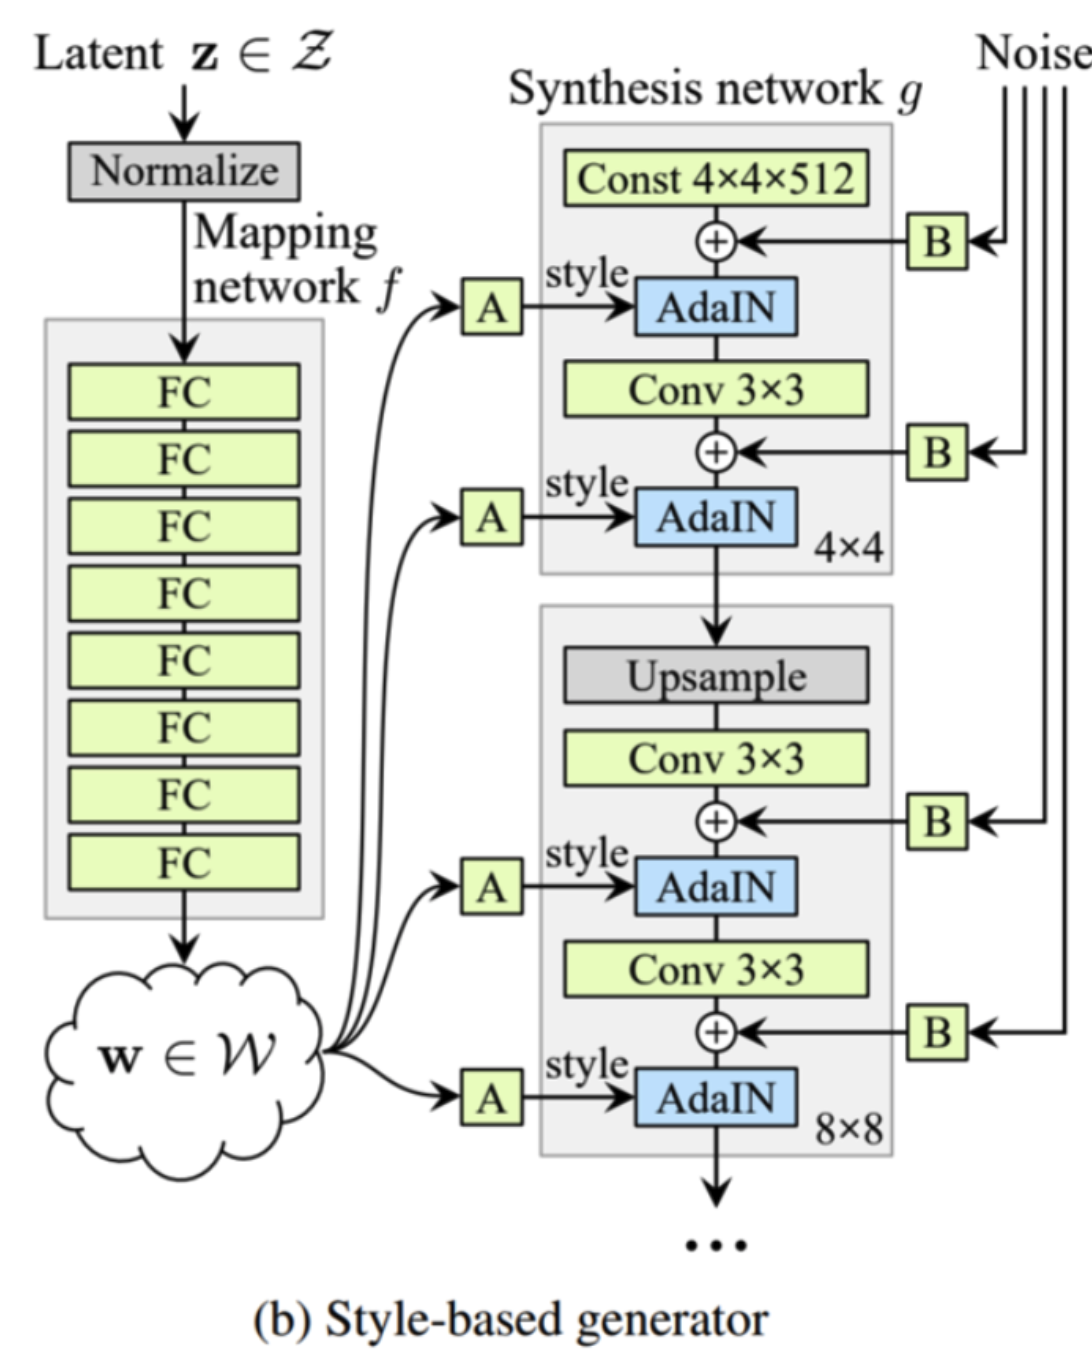

In [9]:
from IPython.display import Image
# StyleGAN의 각 모듈
Image(stylegan_gen_struc, width=300, height=400)

In [10]:
# styleGAN의 affine transform(A) 모듈
class FC_A(nn.Module):
    '''
    midiate vector(w)를 style vector로 변환해준다.
    '''
    def __init__(self, dim_latent, n_channel):
        super().__init__()
        self.transform = SLinear(dim_latent, n_channel * 2)

        self.transform.linear.bias.data[:n_channel] = 1
        self.transform.linear.bias.data[n_channel:] = 0

    def forward(self, w):
        # Gain scale factor and bias with:
        style = self.transform(w).unsqueeze(2).unsqueeze(3)
        return style

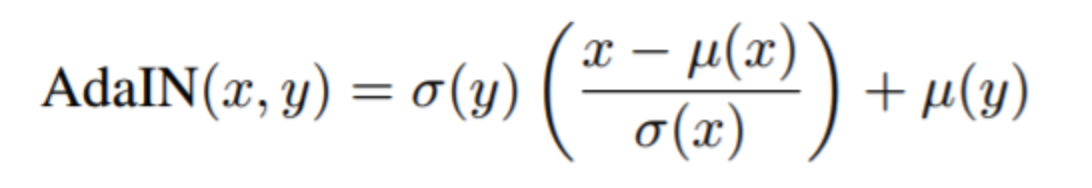

In [11]:
from IPython.display import Image
Image(adain_form)

In [12]:
# AdaIn(AdaptiveInstanceNorm) 모듈
class AdaIn(nn.Module):
    '''
    adaptive instance normalization을 수행한다.
    '''
    def __init__(self, n_channel):
        super().__init__()
        self.norm = nn.InstanceNorm2d(n_channel)
        
    def forward(self, image, style):
        factor, bias = style.chunk(2, 1)
        result = self.norm(image)
        result = result * factor + bias  
        return result


In [13]:
# StyleGAN의 Noise scaling(B) 모듈 
class Scale_B(nn.Module):
    '''
    StyleGAN의 Noise(B)의 적용 scale 값을 학습을 통해 결정해주게 된다.
    이때의 scale 값을 입력받은 noise(B)에 곱해서 forward.(각 scale 값은 channel 수 만큼 존재.)
    '''
    def __init__(self, n_channel):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros((1, n_channel, 1, 1)))
    
    def forward(self, noise):
        result = noise * self.weight
        return result 

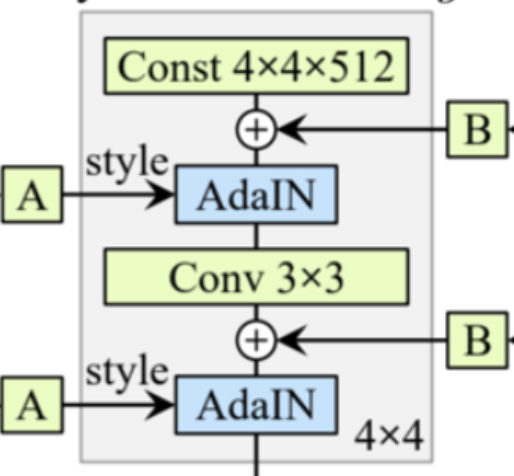

In [14]:
from IPython.display import Image
Image(early_styleconv_block, width=300, height=400)

In [15]:
# StyleGAN의 Synthesis network(g)의 첫번째 conv block
class Early_StyleConv_Block(nn.Module):
    '''
    4x4x512의 const input tensor로 시작하는 Synthesis network(g).
    forward시에 const tensor로 시작하여 (+ noise, ADAIN, lrelu)를 적용한 뒤
    conv하고 다시 (+ noise, ADAIN, lrelu)를 수행한다.
    '''
    def __init__ (self, n_channel, dim_latent, dim_input):
        super().__init__()
        # Constant input tensor
        self.constant = nn.Parameter(torch.randn(1, n_channel, dim_input, dim_input))
        # style vector를 만들기 위해 StyleGAN의 affine transform(A)를 적용하는 모듈
        self.style1   = FC_A(dim_latent, n_channel)
        self.style2   = FC_A(dim_latent, n_channel)
        # StyleGAN의 Noise scaling(B)를 적용하는 모듈
        self.noise1   = quick_scale(Scale_B(n_channel))
        self.noise2   = quick_scale(Scale_B(n_channel))
        # AdaIn 적용 모듈
        self.adain    = AdaIn(n_channel)
        self.lrelu    = nn.LeakyReLU(0.2)
        # Convolutional 적용 모듈
        self.conv     = SConv2d(n_channel, n_channel, 3, padding=1)
    
    def forward(self, latent_w, noise):
        result = self.constant.repeat(noise.shape[0], 1, 1, 1)
        result = result + self.noise1(noise)
        result = self.adain(result, self.style1(latent_w))
        result = self.lrelu(result)
        result = self.conv(result)
        result = result + self.noise2(noise)
        result = self.adain(result, self.style2(latent_w))
        result = self.lrelu(result)
        
        return result
    
# StyleGAN의 Synthesis network(g)의 첫번째가 아닌 conv block
class StyleConv_Block(nn.Module):
    '''
    위의 Early_StyleConv_Block에서 Constant input tensor 부분이 
    Convolutoin으로 대체되고 동일하다.
    '''
    def __init__ (self, in_channel, out_channel, dim_latent):
        super().__init__()

        self.style1   = FC_A(dim_latent, out_channel)
        self.style2   = FC_A(dim_latent, out_channel)

        self.noise1   = quick_scale(Scale_B(out_channel))
        self.noise2   = quick_scale(Scale_B(out_channel))

        self.adain    = AdaIn(out_channel)
        self.lrelu    = nn.LeakyReLU(0.2)

        self.conv1    = SConv2d(in_channel, out_channel, 3, padding=1)
        self.conv2    = SConv2d(out_channel, out_channel, 3, padding=1)
    
    def forward(self, previous_result, latent_w, noise):

        result = self.conv1(previous_result)
        result = result + self.noise1(noise)
        result = self.adain(result, self.style1(latent_w))
        result = self.lrelu(result)
        result = self.conv2(result)
        result = result + self.noise2(noise)
        result = self.adain(result, self.style2(latent_w))
        result = self.lrelu(result)
        
        return result    


In [16]:
# StyleGAN용 conv block이 아닌 일반적인 conv block
class ConvBlock(nn.Module):
    '''
    Progressive discriminator를 만들기 위해 사용되는 convolutoin block.
    '''
    def __init__(self, in_channel, out_channel, size_kernel1, padding1, 
                 size_kernel2 = None, padding2 = None):
        super().__init__()
        
        if size_kernel2 == None:
            size_kernel2 = size_kernel1
        if padding2 == None:
            padding2 = padding1
        
        self.conv = nn.Sequential(
            SConv2d(in_channel, out_channel, size_kernel1, padding=padding1),
            nn.LeakyReLU(0.2),
            SConv2d(out_channel, out_channel, size_kernel2, padding=padding2),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, image):
        result = self.conv(image)
        return result
        

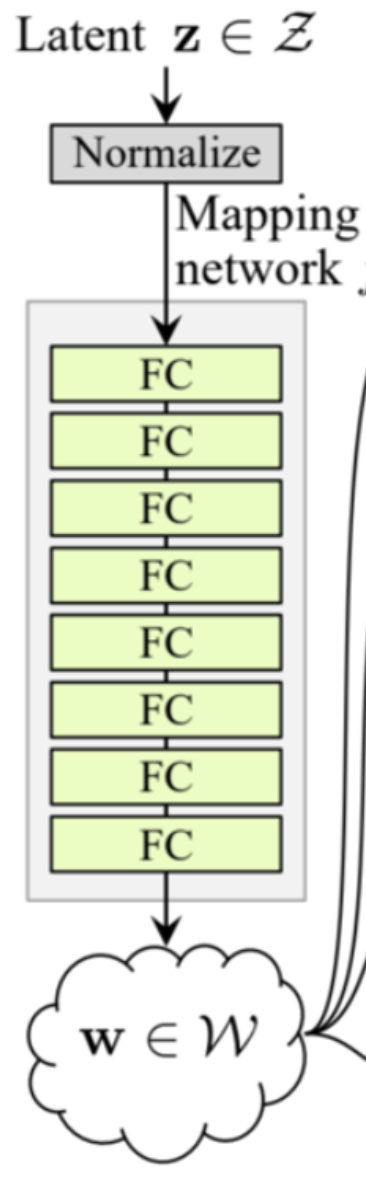

In [17]:
from IPython.display import Image
Image(intermediate_generator)

In [18]:
# StyleGAN의 main인 Mapping network(f)
class Intermediate_Generator(nn.Module):
    '''
    Latent z를 입력으로 받아 FC layer들을 통해 sytle vector w로
    변환시켜 준다.
    '''
    def __init__(self, n_fc, dim_latent):
        super().__init__()
        layers = [PixelNorm()]
        for i in range(n_fc):
            layers.append(SLinear(dim_latent, dim_latent))
            layers.append(nn.LeakyReLU(0.2))
            
        self.mapping = nn.Sequential(*layers)
    
    def forward(self, latent_z):
        latent_w = self.mapping(latent_z)
        return latent_w    


In [19]:
# Generator
class StyleBased_Generator(nn.Module):
    '''
    StyleGAN의 systhesis network(g)
    '''
    def __init__(self, n_fc, dim_latent, dim_input):
        super().__init__()
        # Mapping network(f)
        self.fcs    = Intermediate_Generator(n_fc, dim_latent)
        # Synthesis network(g)의 각 convolutoin 모듈들
        self.convs  = nn.ModuleList([
            Early_StyleConv_Block(512, dim_latent, dim_input),
            StyleConv_Block(512, 512, dim_latent),
            StyleConv_Block(512, 512, dim_latent),
            StyleConv_Block(512, 512, dim_latent),
            StyleConv_Block(512, 256, dim_latent),
            StyleConv_Block(256, 128, dim_latent),
            StyleConv_Block(128, 64, dim_latent),
            StyleConv_Block(64, 32, dim_latent),
            StyleConv_Block(32, 16, dim_latent)
        ])
        # Synthesis network(g)의 중간 feature들을 rgb이미지로 변환해주는 모듈들
        self.to_rgbs = nn.ModuleList([
            SConv2d(512, 3, 1),
            SConv2d(512, 3, 1),
            SConv2d(512, 3, 1),
            SConv2d(512, 3, 1),
            SConv2d(256, 3, 1),
            SConv2d(128, 3, 1),
            SConv2d(64, 3, 1),
            SConv2d(32, 3, 1),
            SConv2d(16, 3, 1)
        ])
    def forward(self, latent_z, step = 0, alpha=-1, noise=None, mix_steps=[]):
        '''
        latent_z: StyleGAN에서 사용하는 Latent(z) 
        step: train할 레이어(4 x 4부터 카운트)의 수
        alpha: 마지막 layer에서 3channel rgb이미지를 만들때 step-1의 이미지를 alpha만큼 참고하여 더 좋은 이미지 만들어준다.
        noise: StyleGAN에서 사용하는 Noise
        mix_steps: mix_steps보다 작은 step에서는 latent_z[1]사용. 반대의 경우엔 latent_z[0] 사용.
        '''
        if type(latent_z) != type([]):
            print('You should use list to package your latent_z')
            latent_z = [latent_z]
        if (len(latent_z) != 2 and len(mix_steps) > 0) or type(mix_steps) != type([]):
            print('Warning: Style mixing disabled, possible reasons:')
            print('- Invalid number of latent vectors')
            print('- Invalid parameter type: mix_steps')
            mix_steps = []
        
        # Latent(z)와 Mapping network(f)를 통해  style vector(w) 추출.
        latent_w = [self.fcs(latent) for latent in latent_z]
        batch_size = latent_w[0].size(0)
        
        result = 0
        current_latent = 0
        
        # step수 까지 convolution block을 사용하여 systhesis 이미지 생성.
        for i, conv in enumerate(self.convs):
            # mix_steps에 따라 해상도에 지정한 스타일 입히기.
            if i in mix_steps:
                current_latent = latent_w[1]
            else:
                current_latent = latent_w[0]
                
            # Not the first layer, need to upsample
            if i > 0 and step > 0:
                result_upsample = nn.functional.interpolate(result, scale_factor=2, mode='bilinear',
                                                  align_corners=False)
                result = conv(result_upsample, current_latent, noise[i])
            else:
                result = conv(current_latent, noise[i])
            
            # 마지막 레이어이면 현재 feature를 rgb이미지로 변환.
            if i == step:
                result = self.to_rgbs[i](result)
                
                if i > 0 and 0 <= alpha < 1:
                    result_prev = self.to_rgbs[i - 1](result_upsample)
                    result = alpha * result + (1 - alpha) * result_prev
                    
                # Finish and break
                break
        
        return result
    
# Discriminator
class Discriminator(nn.Module):
    '''
    Main Module
    '''
    def __init__(self):
        super().__init__()
        # 합성된 rgb이미지를 distriminator로 변환해주는 Sconv block 모듈 리스트
        self.from_rgbs = nn.ModuleList([
            SConv2d(3, 16, 1),
            SConv2d(3, 32, 1),
            SConv2d(3, 64, 1),
            SConv2d(3, 128, 1),
            SConv2d(3, 256, 1),
            SConv2d(3, 512, 1),
            SConv2d(3, 512, 1),
            SConv2d(3, 512, 1),
            SConv2d(3, 512, 1)
       ])
        # distriminator의 Conv Block 모듈 리스트
        self.convs  = nn.ModuleList([
            ConvBlock(16, 32, 3, 1),
            ConvBlock(32, 64, 3, 1),
            ConvBlock(64, 128, 3, 1),
            ConvBlock(128, 256, 3, 1),
            ConvBlock(256, 512, 3, 1),
            ConvBlock(512, 512, 3, 1),
            ConvBlock(512, 512, 3, 1),
            ConvBlock(512, 512, 3, 1),
            ConvBlock(513, 512, 3, 1, 4, 0)
        ])
        self.fc = SLinear(512, 1)
        
        self.n_layer = 9 # 9 layers network
    
    def forward(self, image, 
                step = 0,  # Step means how many layers (count from 4 x 4) are used to train
                alpha=-1):  # Alpha is the parameter of smooth conversion of resolution):
        '''
        step: train할 레이어(4 x 4부터 카운트)의 수
        alpha: 마지막 layer에서 3channel rgb이미지를 만들때 step-1의 이미지를 alpha만큼 참고하여 더 좋은 이미지 만들어준다.
        '''
        
        # step에서 부터 차례로 convs에서 distriminator의 conv block을 가져온다.
        for i in range(step, -1, -1):
            layer_index = self.n_layer - i - 1 
            
            # step layer라면 rgb이미지를 distriminator의 feature shape에 맞춰주는 Sconv수행
            if i == step: 
                result = self.from_rgbs[layer_index](image)
            
            # step 0 의 conv 전에 미니배치 표준 편차를 사용한 variation 증가 (improved techniques for GAN)
            # ?: GAN을 통해 합성된 이미지가 training data의 variation의 subset만 알아내는 경향을 개선
            # ?: 이미지 뿐만 아니라 미니 배치에서도 특징의 통계량을 계산  →  미니 배치에서도 비슷한 통계량이 나오도록 유도
            # ?: discriminator의 중간 layer 특징 :  f(xi)  를 학습되는 큰 텐서  T 와 곱해 vector로 사영시킴
            # ?: 이러한 벡터들을 이용한 통계량을 미니배치안의 각 관측치마다 적용하여 concat해서 다음 layer로 넘김
            # ?: 출처: https://ml-dnn.tistory.com/8
            if i == 0:
                res_var = result.var(0, unbiased=False) + 1e-8 # Avoid zero
                res_std = torch.sqrt(res_var)
                mean_std = res_std.mean().expand(result.size(0), 1, 4, 4)
                result = torch.cat([result, mean_std], 1)
            
            # Conv
            result = self.convs[layer_index](result)
            
            # 마지막 block이 아닐때
            if i > 0:
                result = nn.functional.interpolate(result, scale_factor=0.5, mode='bilinear',
                                                  align_corners=False)
                # 첫 block(i == step)이라면 alpha 비율만큼 다음 레이어 이미지와 더하여 discriminator에 더 나은 특징 제공
                if i == step and 0 <= alpha < 1:
                    result_next = self.from_rgbs[layer_index + 1](image)
                    result_next = nn.functional.interpolate(result_next, scale_factor=0.5,
                                                           mode = 'bilinear', align_corners=False)
                
                    result = alpha * result + (1 - alpha) * result_next
                    
        # distriminator의 임베딩을 fc에 태워서 logit을 얻는다.
        result = result.squeeze(2).squeeze(2)
        result = self.fc(result)
        return result

In [20]:
import os
#os.environ['CUDA_VISIBLE_DEVICES']='1, 2'
n_gpu             = 0
device            = torch.device('cpu')

learning_rate     = {128: 0.0015, 256: 0.002, 512: 0.003, 1024: 0.003}
batch_size_1gpu   = {4: 128, 8: 128, 16: 64, 32: 32, 64: 16, 128: 16}
mini_batch_size_1 = 8
batch_size        = {4: 256, 8: 256, 16: 128, 32: 64, 64: 32, 128: 16}
mini_batch_size   = 8
batch_size_4gpus  = {4: 512, 8: 256, 16: 128, 32: 64, 64: 32}
mini_batch_size_4 = 16
batch_size_8gpus  = {4: 512, 8: 256, 16: 128, 32: 64}
mini_batch_size_8 = 32
n_fc              = 8
dim_latent        = 512
dim_input         = 4
n_sample          = 120000
DGR               = 1
n_show_loss       = 40
step              = 1 
max_step          = 8 
style_mixing      = [] 
image_folder_path = './dataset/'
save_folder_path  = './results/'

low_steps         = [0, 1, 2]
# style_mixing    += low_steps
mid_steps         = [3, 4, 5]
# style_mixing    += mid_steps
hig_steps         = [6, 7, 8]
# style_mixing    += hig_steps

# Used to continue training from last checkpoint
startpoint        = 0
used_sample       = 0
alpha             = 0

# Mode: Evaluate? Train?
is_train          = True

# How to start training?
# True for start from saved model
# False for retrain from the very beginning
is_continue       = False
d_losses          = [float('inf')]
g_losses          = [float('inf')]
inputs, outputs = [], []


In [21]:
def set_grad_flag(module, flag):
    for p in module.parameters():
        p.requires_grad = flag

def reset_LR(optimizer, lr):
    for pam_group in optimizer.param_groups:
        mul = pam_group.get('mul', 1)
        pam_group['lr'] = lr * mul
        
def gain_sample(dataset, batch_size, image_size=4):
    transform = transforms.Compose([
            transforms.Resize(image_size),          # Resize to the same size
            transforms.CenterCrop(image_size),      # Crop to get square area
            transforms.RandomHorizontalFlip(),      # Increase number of samples
            transforms.ToTensor(),            
            transforms.Normalize((0.5, 0.5, 0.5),
                                 (0.5, 0.5, 0.5))])

    dataset.transform = transform
    loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=8)

    return loader

def imshow(tensor, i):
    grid = tensor[0]
    grid.clamp_(-1, 1).add_(1).div_(2)
    # Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
    ndarr = grid.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    img = Image.fromarray(ndarr)
    img.save(f'{save_folder_path}sample-iter{i}.png')
    plt.imshow(img)
    plt.show()
    

In [28]:
# Train 함수
def train(generator, discriminator, g_optim, d_optim, dataset, step, startpoint=0, used_sample=0,
         d_losses = [], g_losses = [], alpha=0):
    
    # 학습에 필요한 parameter들 설정
    resolution  = 4 * 2 ** step
    
    origin_loader = gain_sample(dataset, batch_size.get(resolution, mini_batch_size), resolution)
    data_loader = iter(origin_loader)
    
    reset_LR(g_optim, learning_rate.get(resolution, 0.001))
    reset_LR(d_optim, learning_rate.get(resolution, 0.001))
    
    progress_bar = tqdm(range(startpoint + 1, n_sample * 5))
    
    # Train
    for i in progress_bar:
        alpha = min(1, alpha + batch_size.get(resolution, mini_batch_size) / (n_sample * 2))
        
        if used_sample > n_sample * 2 and step < max_step: 
            step += 1
            
            alpha = 0
            used_sample = 0
            
            resolution = 4 * 2 ** step
            
            # Avoid possble memory leak
            del origin_loader
            del data_loader
            
            # batch size 변경
            origin_loader = gain_sample(dataset, batch_size.get(resolution, mini_batch_size), resolution)
            data_loader = iter(origin_loader)
            
            reset_LR(g_optim, learning_rate.get(resolution, 0.001))
            reset_LR(d_optim, learning_rate.get(resolution, 0.001))
            
        
        # 데이터 집합이 모두 사용되면 첫 번째 이미지에서 학습
        try:
            real_image, label = next(data_loader)
        except (OSError, StopIteration):
            data_loader = iter(origin_loader)
            real_image, label = next(data_loader)
        
        # 사용된 image 수 계산
        used_sample += real_image.shape[0]
        real_image = real_image.to(device)
        
        # ----------------- Discriminator module 학습 부분 ----------------- #
        discriminator.zero_grad()
        set_grad_flag(discriminator, True)
        set_grad_flag(generator, False)
        
        # Real image를 사용하여 distriminator의 gradients를 계산한다.
        real_image.requires_grad = True
        if n_gpu > 1:
            real_predict = nn.parallel.data_parallel(discriminator, (real_image, step, alpha), range(n_gpu))
        else:
            real_predict = discriminator(real_image, step, alpha)
        real_predict = nn.functional.softplus(-real_predict).mean()
        real_predict.backward(retain_graph=True)

        grad_real = torch.autograd.grad(outputs=real_predict.sum(), inputs=real_image, create_graph=True)[0]
        grad_penalty_real = (grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2).mean()
        grad_penalty_real = 10 / 2 * grad_penalty_real
        grad_penalty_real.backward()
        
        # Generator의 latent와 noise를 mini-batch size만큼 생성
        latent_w1 = [torch.randn((batch_size.get(resolution, mini_batch_size), dim_latent), device=device)]
        latent_w2 = [torch.randn((batch_size.get(resolution, mini_batch_size), dim_latent), device=device)]
        
        noise_1 = []
        noise_2 = []
        for m in range(step + 1):
            size = 4 * 2 ** m 
            noise_1.append(torch.randn((batch_size.get(resolution, mini_batch_size), 1, size, size), device=device))
            noise_2.append(torch.randn((batch_size.get(resolution, mini_batch_size), 1, size, size), device=device))
        
        # fake 이미지를 합성하고 합성된 것을 통해 distriminator의 gradients를 계산한다.
        if n_gpu > 1:
            fake_image = nn.parallel.data_parallel(generator, (latent_w1, step, alpha, noise_1), range(n_gpu))
            fake_predict = nn.parallel.data_parallel(discriminator, (fake_image, step, alpha), range(n_gpu))
        else:
            fake_image = generator(latent_w1, step, alpha, noise_1)
            fake_predict = discriminator(fake_image, step, alpha)

        fake_predict = nn.functional.softplus(fake_predict).mean()
        fake_predict.backward()
        
        if i % n_show_loss == 0:
            d_losses.append((real_predict + fake_predict).item())
        
        # Discriminator optimize
        d_optim.step()
        
        del grad_penalty_real, grad_real, fake_predict, real_predict, fake_image, real_image, latent_w1
                   
        # ----------------- Generator module 학습 부분 ----------------- #
        # 매 DGR iteration 후에 generator 학습
        if i % DGR != 0: continue
        generator.zero_grad()
        set_grad_flag(discriminator, False)
        set_grad_flag(generator, True)
        
        if n_gpu > 1:
            fake_image = nn.parallel.data_parallel(generator, (latent_w2, step, alpha, noise_2), range(n_gpu))
            fake_predict = nn.parallel.data_parallel(discriminator, (fake_image, step, alpha), range(n_gpu))
        else: 
            fake_image = generator(latent_w2, step, alpha, noise_2)
            fake_predict = discriminator(fake_image, step, alpha)
        fake_predict = nn.functional.softplus(-fake_predict).mean()
        fake_predict.backward()
        g_optim.step()

        if i % n_show_loss == 0:
            g_losses.append(fake_predict.item())
            imshow(fake_image.data.cpu(), i)
            
        del fake_predict, fake_image, latent_w2
        
        # 모델 저장
        if (i + 1) % 1000 == 0:
            torch.save({
                'generator'    : generator.state_dict(),
                'discriminator': discriminator.state_dict(),
                'g_optim'      : g_optim.state_dict(),
                'd_optim'      : d_optim.state_dict(),
                'parameters'   : (step, i, used_sample, alpha),
                'd_losses'     : d_losses,
                'g_losses'     : g_losses
            }, 'checkpoint/trained.pth')
            print(f'Iteration {i} successfully saved.')
        
        progress_bar.set_description((f'Resolution: {resolution}*{resolution}  D_Loss: {d_losses[-1]:.4f}  G_Loss: {g_losses[-1]:.4f}  Alpha: {alpha:.4f}'))
        
    return d_losses, g_losses


In [29]:
generator      = StyleBased_Generator(n_fc, dim_latent, dim_input).to(device)
discriminator  = Discriminator().to(device)
g_optim        = optim.Adam([{
    'params': generator.convs.parameters(),
    'lr'    : 0.001
}, {
    'params': generator.to_rgbs.parameters(),
    'lr'    : 0.001
}], lr=0.001, betas=(0.0, 0.99))
g_optim.add_param_group({
    'params': generator.fcs.parameters(),
    'lr'    : 0.001 * 0.01,
    'mul'   : 0.01
})
d_optim        = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.0, 0.99))
dataset        = datasets.ImageFolder(image_folder_path)

In [ ]:
# pretrained 된 model을 가져와서 fine-tuning을 진행할 때 pretrain된 값들을 가져온다.
if is_continue:
    if os.path.exists('checkpoint/trained.pth'):
        # Load data from last checkpoint
        print('Loading pre-trained model...')
        checkpoint = torch.load('checkpoint/trained.pth')
        generator.load_state_dict(checkpoint['generator'])
        discriminator.load_state_dict(checkpoint['discriminator'])
        g_optim.load_state_dict(checkpoint['g_optim'])
        d_optim.load_state_dict(checkpoint['d_optim'])
        step, startpoint, used_sample, alpha = checkpoint['parameters']
        d_losses = checkpoint.get('d_losses', [float('inf')])
        g_losses = checkpoint.get('g_losses', [float('inf')])
    else:
        print('No pre-trained model detected, restart training...')
        
if is_train:
    generator.train()
    discriminator.train()
    d_losses, g_losses = train(generator, discriminator, g_optim, d_optim, dataset, step, startpoint, used_sample, d_losses, g_losses, alpha)
else:
    # Do some evaluation here
    pass


  0%|          | 0/599999 [00:00<?, ?it/s]
Resolution: 8*8  D_Loss: inf  G_Loss: inf  Alpha: 0.0011:   0%|          | 0/599999 [00:20<?, ?it/s]
Resolution: 8*8  D_Loss: inf  G_Loss: inf  Alpha: 0.0011:   0%|          | 1/599999 [00:20<3416:15:54, 20.50s/it]
Resolution: 8*8  D_Loss: inf  G_Loss: inf  Alpha: 0.0021:   0%|          | 1/599999 [00:40<3416:15:54, 20.50s/it]
Resolution: 8*8  D_Loss: inf  G_Loss: inf  Alpha: 0.0021:   0%|          | 2/599999 [00:40<3370:16:30, 20.22s/it]
Resolution: 8*8  D_Loss: inf  G_Loss: inf  Alpha: 0.0032:   0%|          | 2/599999 [01:00<3370:16:30, 20.22s/it]
Resolution: 8*8  D_Loss: inf  G_Loss: inf  Alpha: 0.0032:   0%|          | 3/599999 [01:00<3366:11:34, 20.20s/it]
Resolution: 8*8  D_Loss: inf  G_Loss: inf  Alpha: 0.0043:   0%|          | 3/599999 [01:20<3366:11:34, 20.20s/it]
Resolution: 8*8  D_Loss: inf  G_Loss: inf  Alpha: 0.0043:   0%|          | 4/599999 [01:20<3377:20:43, 20.26s/it]
Resolution: 8*8  D_Loss: inf  G_Loss: inf  Alpha: 0.0053: